In [99]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
Requirement already up-to-date: mxnet==1.6.0 in /share/home/tung6100/.local/lib/python3.8/site-packages (1.6.0)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [100]:
# Import libraries
import os
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import r2_score
import os 
from datetime import datetime, timedelta
from datetime import timedelta

In [101]:
file = "traffic.txt"
isExist = os.path.exists(file)
if not isExist:
    print(f"Files not exist")

In [102]:
"""Preprocess data"""
data = pd.read_csv('traffic.txt', delimiter = ',', header=None)
print('data loaded..')
data_2 = data.copy()
#pick the first 20 clients
data_2 = data_2.iloc[:,:20]
#create time column: 2 years 1 hour
data_2['time'] = pd.to_datetime(np.arange(datetime(2015,1,1), datetime(2017,1,1), timedelta(hours=1)))
data_2.index = data_2['time']
data_2 = data_2.drop(['time'], axis = 1)
#create column names
data_3 = data_2.copy()
col_names = ['MT_{0:03}'.format(i+1) for i in range(data_3.shape[1])]
data_3.columns = col_names
aggregated_data = data_3.copy()

data loaded..


In [103]:
aggregated_data.shape

(17544, 20)

In [104]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [105]:
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,-0.936348,-1.154807,-0.569033,-0.500971,-0.765328,-0.665566,-0.660995,-0.414196,-0.822551,-0.854473,-0.914064,-0.568700,-0.899862,-0.569866,-1.335692,-0.748872,-0.798016,-0.608055
2015-01-01 01:00:00,-0.674341,-0.645010,-0.862140,-1.067719,-0.513278,-0.488945,-0.701394,-0.490022,-0.447094,-0.407787,-0.770593,-0.822892,-0.849406,-0.507760,-0.835587,0.155680,-1.213432,-0.748872,-0.514071,-0.599583
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,-0.610849,-0.594173,-0.822705,-0.641794,-0.681695,-0.484698,-0.886055,-0.901844,-0.951011,-0.735623,-1.053028,-0.145701,-1.310521,-0.952812,-0.716423,-0.691364
2015-01-01 03:00:00,-0.727168,-0.826841,-1.022720,-1.296324,-0.666604,-0.672342,-0.886640,-0.810024,-0.959996,-0.602201,-1.015951,-0.929478,-1.023059,-0.923742,-1.177476,-0.839993,-1.321309,-1.093459,-0.977522,-0.729489
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,-0.573359,-1.079455,-0.943294,-1.041533,-1.045622,-1.233545,-1.221742,-1.342884,-1.130380,-1.170083,-0.753493


In [106]:
from gluonts.mx import DeepAREstimator
from gluonts.mx import Trainer

In [107]:
# Hyper-parameters
n_clients = 20
prediction_length = 24
freq = "1H"
train_start = pd.Period("01-01-2015", freq=freq) 
test_start = pd.Period("25-12-2016", freq=freq)
missing_percentage = 40

/home/tung6100/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: UserWarning: Parsing '25-12-2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [108]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    if missing_percentage == 0: return pd_data
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports to randomly choose indices from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,0.000000,-1.154807,0.000000,-0.500971,-0.765328,-0.665566,0.000000,-0.414196,-0.822551,-0.854473,0.000000,0.000000,-0.899862,-0.569866,-1.335692,-0.748872,-0.798016,-0.608055
2015-01-01 01:00:00,-0.674341,-0.645010,-0.862140,-1.067719,-0.513278,0.000000,-0.701394,-0.490022,-0.447094,0.000000,-0.770593,-0.822892,-0.849406,-0.507760,-0.835587,0.155680,-1.213432,0.000000,0.000000,-0.599583
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,-0.610849,-0.594173,-0.822705,-0.641794,-0.681695,-0.484698,-0.886055,0.000000,-0.951011,-0.735623,-1.053028,-0.145701,-1.310521,-0.952812,-0.716423,-0.691364
2015-01-01 03:00:00,-0.727168,0.000000,-1.022720,-1.296324,-0.666604,0.000000,-0.886640,0.000000,0.000000,-0.602201,-1.015951,-0.929478,-1.023059,0.000000,-1.177476,-0.839993,0.000000,-1.093459,-0.977522,-0.729489
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,-0.573359,-1.079455,-0.943294,-1.041533,-1.045622,0.000000,-1.221742,-1.342884,-1.130380,-1.170083,-0.753493


In [109]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:17376,:n_clients] 
    data_test = normalized_data.iloc[17376:,:n_clients]
    return data_train, data_test

In [110]:
data_train, data_test = set_train_test(n_clients=20)
print(data_train.shape)
print(data_test.shape)

(17376, 20)
(168, 20)


In [111]:
data_test.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2016-12-25 00:00:00,-0.707958,-0.694600,-0.985008,-1.127592,-0.549519,-0.589663,-0.760410,-0.680195,-0.727695,-0.549859,-0.790799,-1.047906,-0.843864,-1.072117,-0.914905,-0.877945,-1.015660,-0.796341,-0.634829,-0.619351
2016-12-25 01:00:00,-0.711160,-0.723528,-1.010555,-1.241894,-0.594123,-0.664826,-0.825984,-0.786252,-0.902496,-0.659884,-0.917807,-1.047906,-0.941775,-0.796563,-1.037985,-1.065471,-1.227816,-0.836777,-0.853500,-0.675832
2016-12-25 02:00:00,-0.723967,-0.835106,-1.115175,-1.367083,-0.663816,-0.708421,-0.588279,-0.965453,-1.107197,-0.676976,-1.004404,-1.047906,-1.076633,-1.125109,-1.187048,-1.261927,-1.368055,-0.877214,-1.091753,-0.723841
2016-12-25 03:00:00,-0.723967,-0.868166,-1.169918,-1.413348,-0.700057,-0.727963,-0.932541,-1.091625,-1.415398,-0.618224,-1.070795,-1.047906,-1.113580,-1.141006,-1.266367,-1.469545,-1.418397,-0.905343,-1.261468,-0.754905
2016-12-25 04:00:00,-0.727168,-0.868166,-1.176001,-1.337147,-0.697269,-0.729466,-0.580082,-1.108082,-1.445298,-0.640656,-1.091001,-1.047906,-1.037838,-1.141006,-1.285512,-1.469545,-1.378843,-0.903585,-1.330007,-0.764789


In [112]:
"""Function to split train and test dataset"""
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:17376,:n_clients] #25600; 25968; 26082
    data_test = normalized_data.iloc[17376:17376+prediction_length,:n_clients]
    data_test_deepAR = normalized_data.iloc[:17376+prediction_length,:n_clients]
    return data_train, data_test, data_test_deepAR

In [113]:
"""Check train and test dataset"""
data_train, data_test, data_test_deepAR = set_train_test(n_clients=20)
data_train.shape, data_test.shape, data_test_deepAR.shape

((17376, 20), (24, 20), (17400, 20))

In [114]:
data_train_missing_vals = create_missing_data(data_train, missing_percentage=missing_percentage)
data_train_missing_vals.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,0.000000,-1.154807,0.000000,-0.500971,-0.765328,-0.665566,0.000000,-0.414196,-0.822551,-0.854473,0.000000,0.000000,0.000000,-0.569866,-1.335692,-0.748872,-0.798016,-0.608055
2015-01-01 01:00:00,-0.674341,-0.645010,0.000000,0.000000,-0.513278,0.000000,0.000000,-0.490022,-0.447094,0.000000,-0.770593,-0.822892,-0.849406,-0.507760,0.000000,0.000000,-1.213432,0.000000,0.000000,-0.599583
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,0.000000,0.000000,-0.822705,-0.641794,0.000000,-0.484698,-0.886055,0.000000,-0.951011,-0.735623,-1.053028,-0.145701,-1.310521,-0.952812,0.000000,-0.691364
2015-01-01 03:00:00,-0.727168,0.000000,0.000000,-1.296324,-0.666604,0.000000,-0.886640,0.000000,0.000000,-0.602201,-1.015951,-0.929478,-1.023059,0.000000,-1.177476,-0.839993,0.000000,0.000000,-0.977522,-0.729489
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,0.000000,-0.706917,0.000000,-0.948996,-1.114097,0.000000,-1.079455,-0.943294,-1.041533,-1.045622,0.000000,-1.221742,0.000000,-1.130380,0.000000,0.000000


In [115]:
data_train_missing_vals.iloc[:, :n_clients].to_numpy().shape

(17376, 20)

In [116]:
"""Convert data to numpy"""
data_train_np = data_train_missing_vals.iloc[:, :n_clients].to_numpy()
data_test_np = data_test.iloc[:, :n_clients].to_numpy()
data_test_deepAR_np = data_test_deepAR.iloc[:, :n_clients].to_numpy()
data_train_np = data_train_np.T
data_test_np = data_test_np.T
data_test_deepAR_np = data_test_deepAR_np.T
# Check the type of data
type(data_train_np), data_train_np.shape, data_test_np.shape, data_test_deepAR_np.shape

(numpy.ndarray, (20, 17376), (20, 24), (20, 17400))

In [117]:
"""Create dataset for Gluont"""
from gluonts.dataset.common import ListDataset
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": train_start} for x in data_train_np[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": train_start} for x in data_test_deepAR_np], freq=freq
)

In [118]:
estimator = DeepAREstimator(freq=freq,
                            prediction_length=prediction_length,
                            trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
                            )

In [119]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 100/100 [00:17<00:00,  5.78it/s, epoch=5/5, avg_epoch_loss=0.29]


In [120]:
from gluonts.evaluation import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=1, 
)

In [121]:
from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=data_test_deepAR_np.shape[1]))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=data_test_deepAR_np.shape[1]))

Obtaining time series conditioning values ...


  0%|          | 0/17400 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/17400 [00:00<?, ?it/s]

In [122]:
import matplotlib.pyplot as plt

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

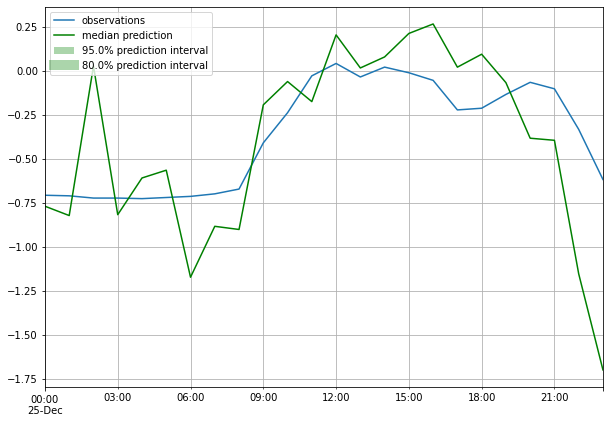

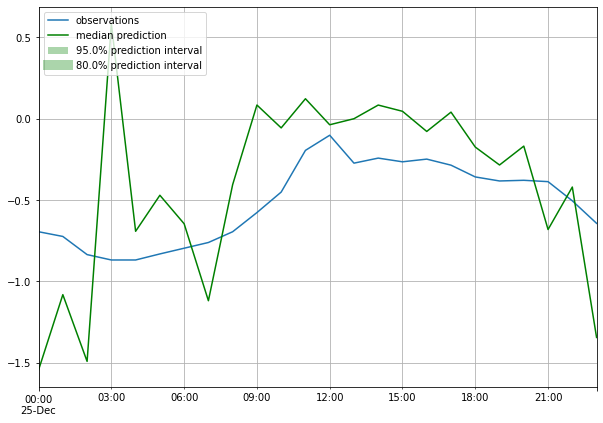

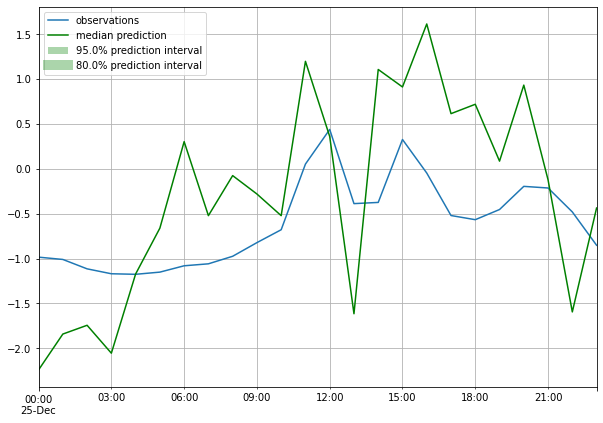

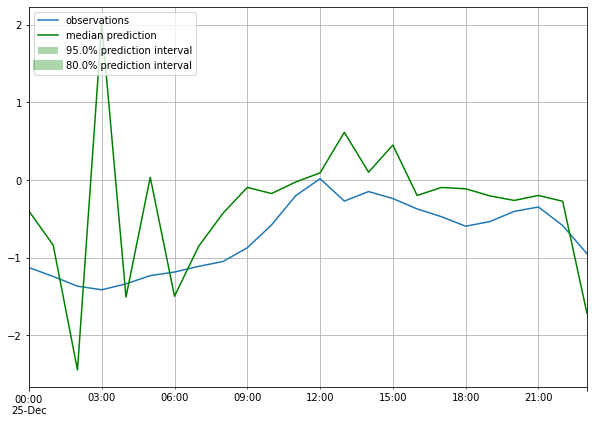

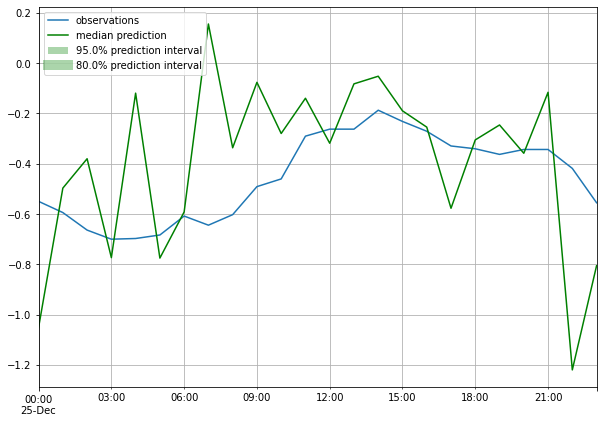

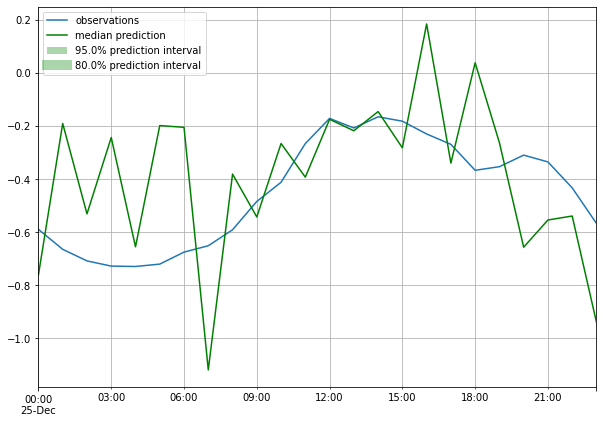

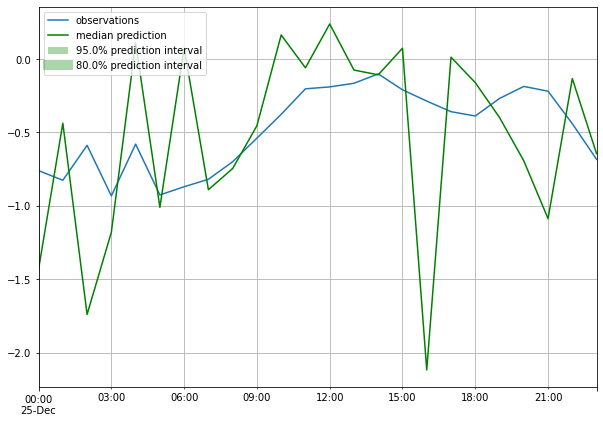

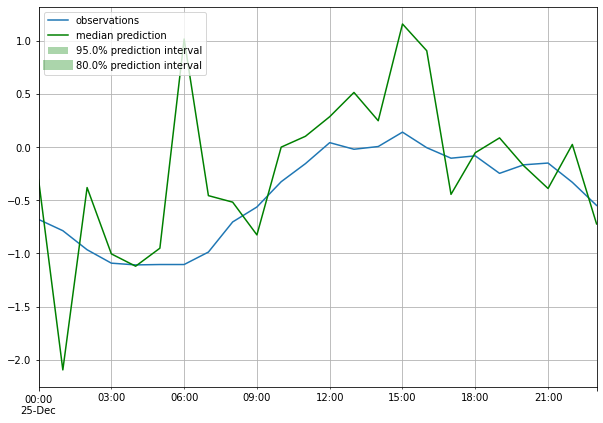

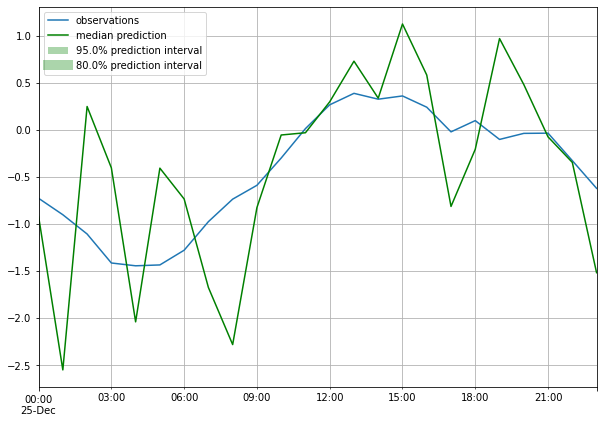

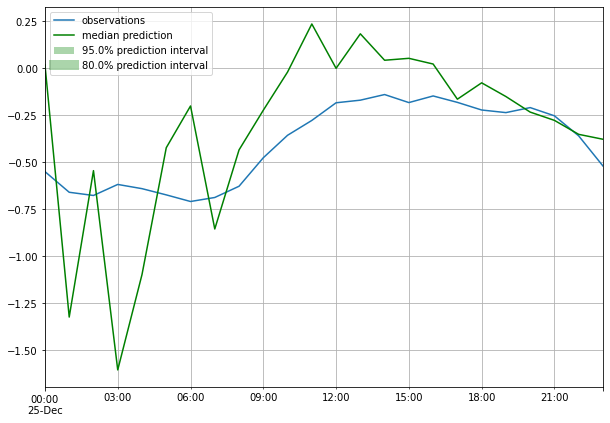

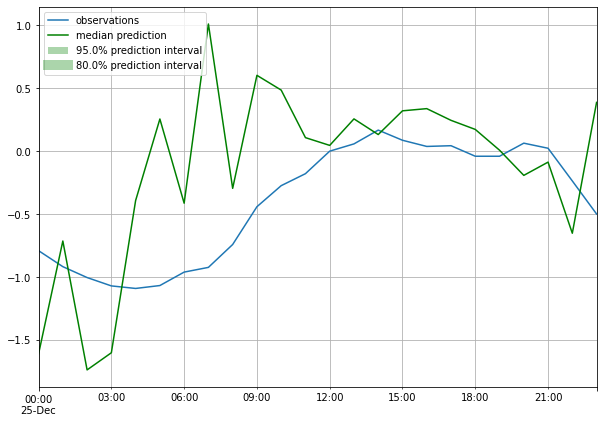

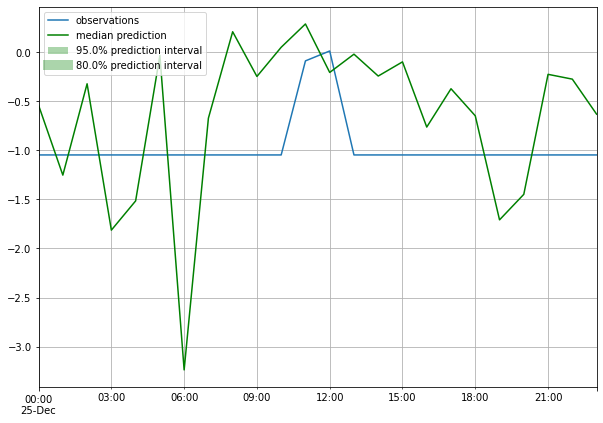

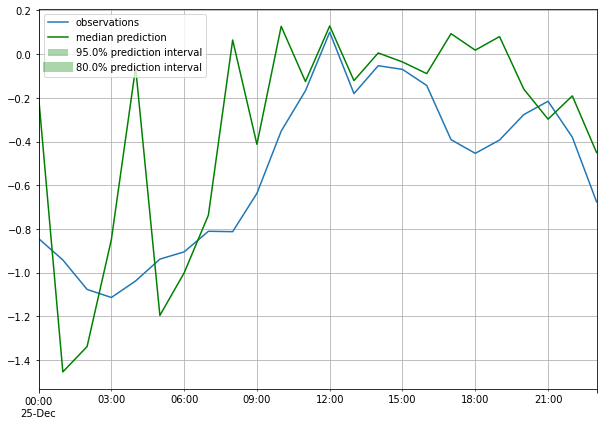

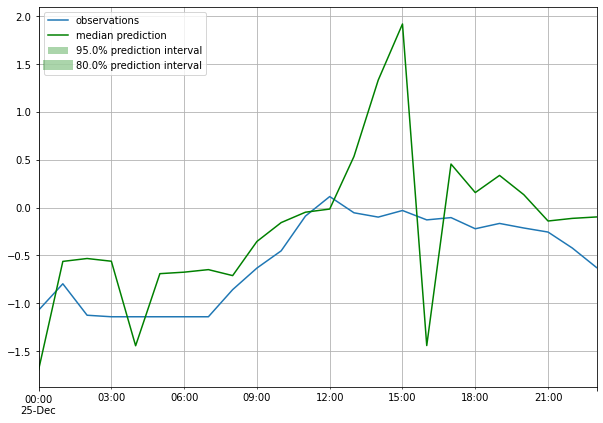

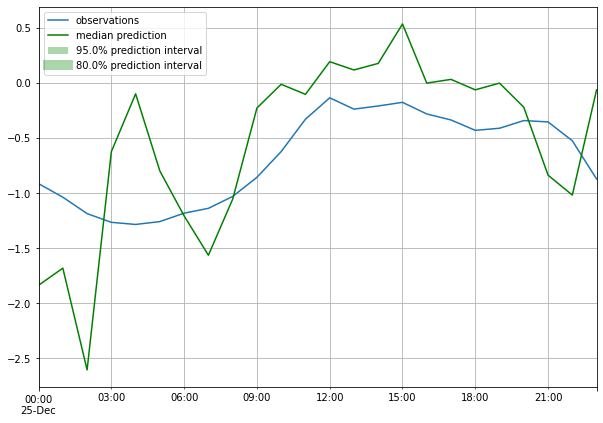

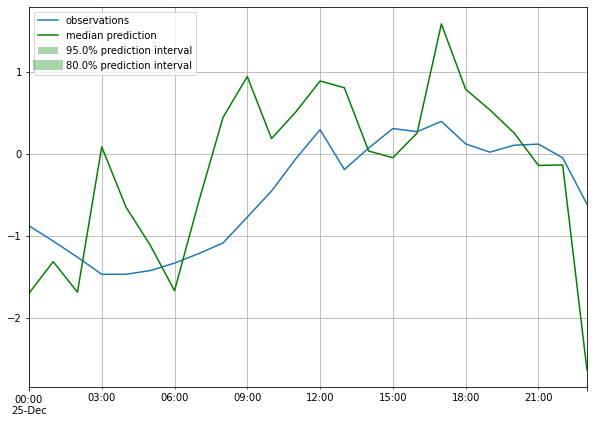

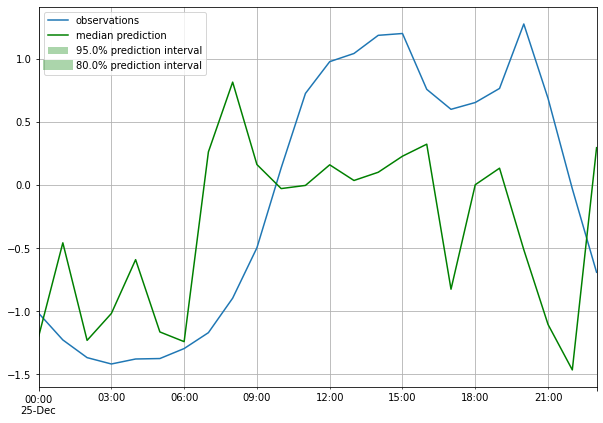

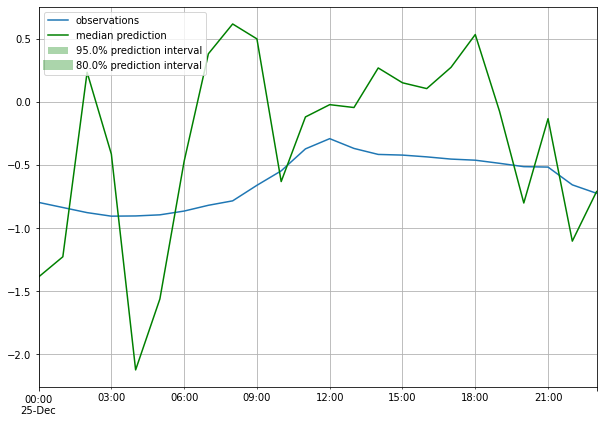

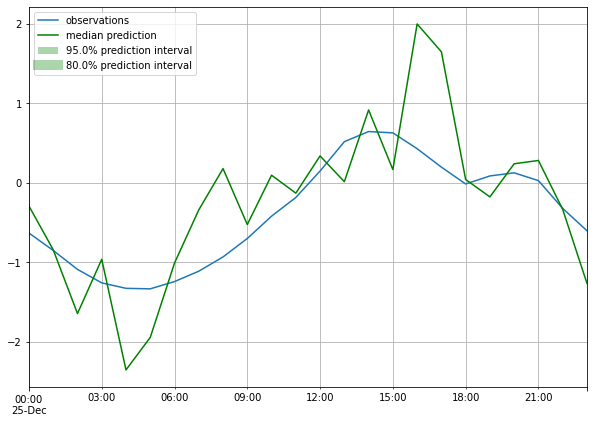

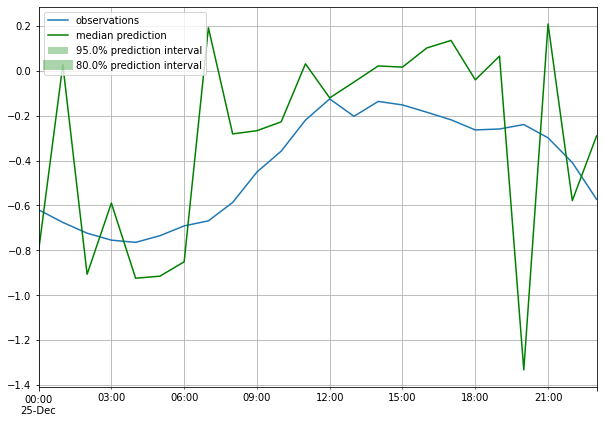

In [123]:
for i in tqdm(range(n_clients)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

In [124]:
list_diff = []
y_pred = []
y_true = []
for i in tqdm(range(n_clients)):
    ts_entry = tss[i]
    ts_entry_np = ts_entry.to_numpy()
    ts_entry_24h = ts_entry_np[-24:, :]
    ts_entry_24h = ts_entry_24h.reshape(-1)
    forecast_entry_24h = forecasts[i].mean
    diff = ts_entry_24h - forecast_entry_24h
    y_pred.append(forecast_entry_24h)
    y_true.append(ts_entry_24h)
    list_diff.append(diff)

y_pred_np = np.array(y_pred)
y_true_np = np.array(y_true)

y_pred_np.shape, y_true_np.shape

  0%|          | 0/20 [00:00<?, ?it/s]

((20, 24), (20, 24))

In [125]:
dif_matrix = np.array(list_diff)
dif_matrix.shape

(20, 24)

In [126]:
rmse = np.sqrt(np.mean(np.square(dif_matrix)))
rmse

0.6594882

In [127]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

# Function to estimate accuracy for one user
def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

# Function to estimate average accuracy for multiple users
def average_acc(y_true, y_pred):
    n_users = y_true.shape[0]
    acc_list = []
    for i in range(n_users):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]
        acc = accuracy_Testset(y_true_i, y_pred_i)
        acc_list.append(acc)
    acc_np = np.array(acc_list)
    # print(acc_np)
    avg_acc = np.mean(acc_np)
    return avg_acc

In [128]:
MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_np, y_pred_np)
avg_acc = average_acc(y_true_np, y_pred_np)
print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}")
print(f"Avg_Acc: {avg_acc}")

MSE: 0.4349247217178345, RMSE: 0.6594882011413574, MAE: 0.48703062534332275, MAPE: 307.07976818084717
Avg_Acc: 50.434782608695656
